<a href="https://colab.research.google.com/github/subhobrata/deep-learning-for-visual-computing/blob/master/Lecture15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [2]:
!pwd

/content


In [4]:
!unzip DRIVE.zip

Archive:  DRIVE.zip
   creating: DRIVE/test/
   creating: DRIVE/test/1st_manual/
 extracting: DRIVE/test/1st_manual/12_manual1.gif  
 extracting: DRIVE/test/1st_manual/02_manual1.gif  
 extracting: DRIVE/test/1st_manual/03_manual1.gif  
 extracting: DRIVE/test/1st_manual/04_manual1.gif  
 extracting: DRIVE/test/1st_manual/05_manual1.gif  
 extracting: DRIVE/test/1st_manual/06_manual1.gif  
 extracting: DRIVE/test/1st_manual/07_manual1.gif  
 extracting: DRIVE/test/1st_manual/08_manual1.gif  
 extracting: DRIVE/test/1st_manual/09_manual1.gif  
 extracting: DRIVE/test/1st_manual/10_manual1.gif  
 extracting: DRIVE/test/1st_manual/11_manual1.gif  
 extracting: DRIVE/test/1st_manual/01_manual1.gif  
 extracting: DRIVE/test/1st_manual/13_manual1.gif  
 extracting: DRIVE/test/1st_manual/14_manual1.gif  
 extracting: DRIVE/test/1st_manual/15_manual1.gif  
 extracting: DRIVE/test/1st_manual/16_manual1.gif  
 extracting: DRIVE/test/1st_manual/17_manual1.gif  
 extracting: DRIVE/test/1st_manual/

In [0]:
Datapath = 'DRIVE/training/images/'
Labelpath = 'DRIVE/training/1st_manual/'

In [0]:
# crop random 10 x 10 patches from images and also crop corresponding label

def img_transfer(img,imgLabel, bh, bw, no_of_patch):
    
    h = img.shape[0]
    w = img.shape[1]
    c = img.shape[2]
    ImgArr = np.empty((no_of_patch, bh*bw*3))
    LabelArr = np.empty((no_of_patch, bh*bw*1))

    for i in range(no_of_patch):
        ih = random.randint(0, h-bh)
        iw = random.randint(0, w-bw)
        iArrI = img[ih:ih+bh,iw:iw+bw,:]
        iArrL = imgLabel[ih:ih+bh,iw:iw+bw,:]       
        for ci in range(c):
            for bhi in range(bh):
                for bwi in range(bw):
                    ImgArr[i][ci*bh*bw + bhi*bw + bwi] = iArrI[bhi][bwi][ci]
                    if ci ==0:
                        LabelArr[i][ci*bh*bw + bhi*bw + bwi] = iArrL[bhi][bwi][ci]
        
    return ImgArr,LabelArr


In [0]:
patchH = 10 # height of the patch
patchW = 10 # width of the patch
PatchperImage = 1000 # no of patches per image

In [0]:
TrainImages = torch.DoubleTensor(20*PatchperImage,3*patchH*patchW)
TrainLabels = torch.LongTensor(20*PatchperImage,patchH*patchW)

In [0]:
# Read each training image and crop random patches

t_no = 0
for img_no in range(20):
    imD = Image.open(Datapath + str(img_no+21) + '_training.tif')
    imD = np.array(imD)    
    
    imL = Image.open(Labelpath + str(img_no+21) + '_manual1.gif')
    imL = np.array(imL)
    imL = np.reshape(imL, (imL.shape[0],imL.shape[1],1))
    
    imD,imL = img_transfer(imD,imL, patchH, patchW, PatchperImage)
    imD = imD/255.0
    imL = imL/255.0
    for i in range(PatchperImage):
        TrainImages[t_no] = torch.from_numpy(imD[i])
        TrainLabels[t_no] = torch.from_numpy(imL[i])
        t_no = t_no + 1

In [10]:
# Printing Training Image and labels size

print(TrainImages.size())
print(TrainLabels.size())

torch.Size([20000, 300])
torch.Size([20000, 100])


In [0]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

In [12]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(patchH*patchW*3, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(patchH*patchW, patchH*patchW),
            nn.Tanh(),
            nn.Linear(patchH*patchW,patchH*patchW*3),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
    
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=300, bias=True)
    (3): Sigmoid()
  )
)


In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

At Iteration : 1 / 500  ;  Mean-Squared Error : 0.086376
At Iteration : 101 / 500  ;  Mean-Squared Error : 0.002286
At Iteration : 201 / 500  ;  Mean-Squared Error : 0.001090
At Iteration : 301 / 500  ;  Mean-Squared Error : 0.000743
At Iteration : 401 / 500  ;  Mean-Squared Error : 0.000721
Finished Training


Text(0,0.5,'Training loss')

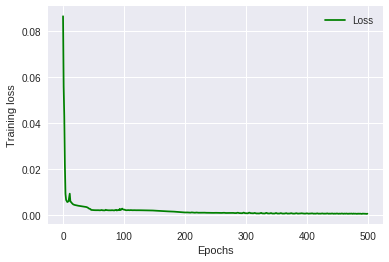

In [14]:
iterations = 500 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]/BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')


fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

In [0]:
# functions to show an image

def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

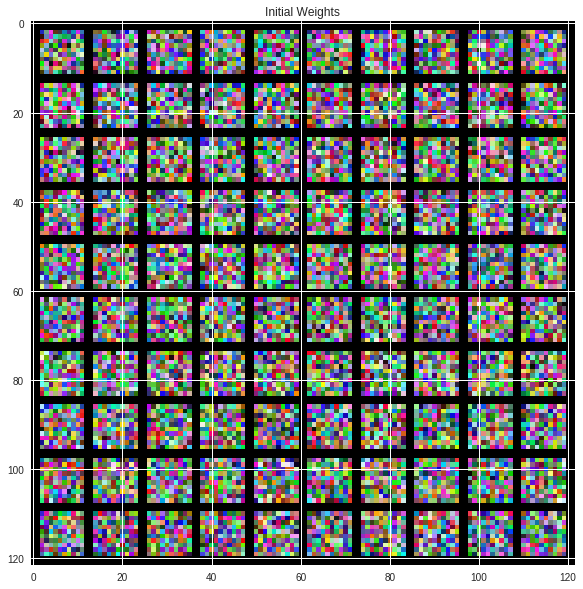

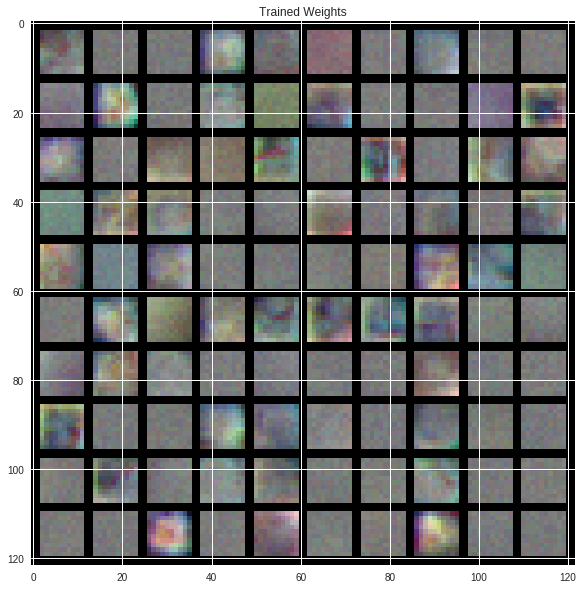

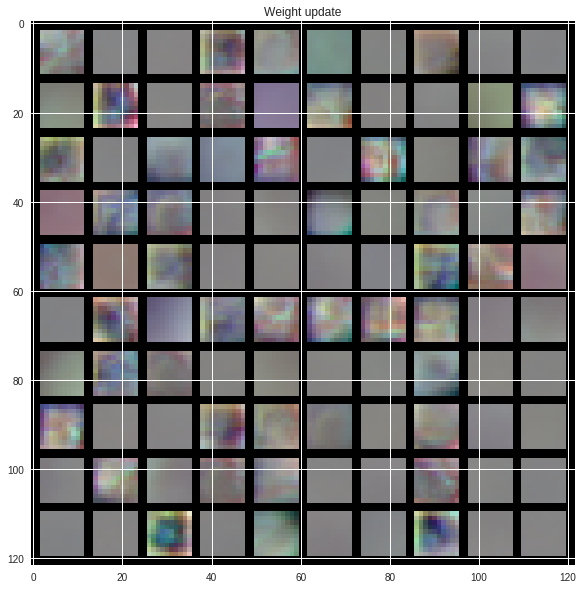

In [16]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
d_weights = init_weights - trained_weights 

if use_gpu:
    init_weights = init_weights.view(100,3,10,10).cpu()
    trained_weights = trained_weights.view(100,3,10,10).cpu()
    d_weights = d_weights.view(100,3,10,10).cpu()
else:
    init_weights = init_weights.view(100,3,10,10)
    trained_weights = trained_weights.view(100,3,10,10)
    d_weights = d_weights.view(100,3,10,10)

imshow(torchvision.utils.make_grid(init_weights,nrow=10,normalize=True),'Initial Weights')
imshow(torchvision.utils.make_grid(trained_weights,nrow=10,normalize=True),'Trained Weights')
imshow(torchvision.utils.make_grid(d_weights,nrow=10,normalize=True), 'Weight update')

In [17]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(patchH*patchW, patchH*patchW),nn.Sigmoid()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Sigmoid()
  )
)


In [0]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

At Iteration: 1 / 500  ;  Training Loss: 0.487978 
At Iteration: 101 / 500  ;  Training Loss: 0.235660 
At Iteration: 201 / 500  ;  Training Loss: 0.196707 
At Iteration: 301 / 500  ;  Training Loss: 0.182524 
At Iteration: 401 / 500  ;  Training Loss: 0.170864 
Finished Training


Text(0,0.5,'Training loss')

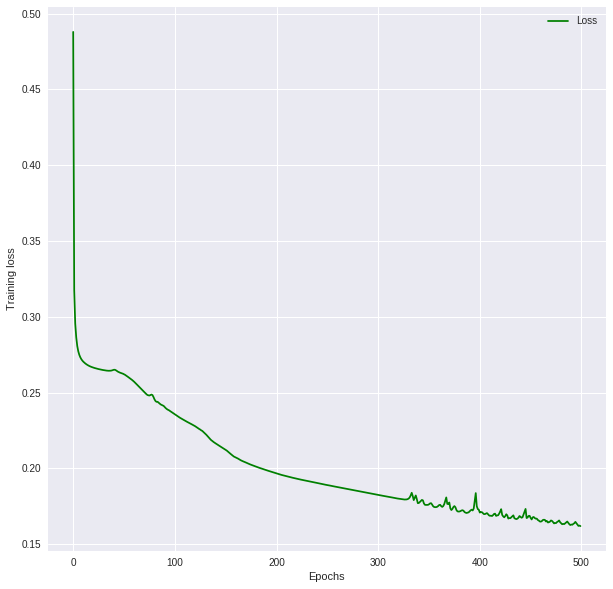

In [20]:
iterations = 500 #1000
BatchSize = 1000
trainLoss = []
for epoch in range(iterations): # loop over the dataset multiple times
    runningLoss = 0
    for i in range(TrainImages.size()[0]/BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad() # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        optimizer.step()
        runningLoss += loss.item()
    trainLoss.append(runningLoss/(TrainImages.size()[0]/BatchSize))
    if epoch%100 == 0:
        print('At Iteration: %d / %d  ;  Training Loss: %f '%(epoch + 1,iterations,runningLoss/(TrainImages.size()[0]/BatchSize)))
print('Finished Training')

fig = plt.figure()        
plt.plot(range(epoch+1),trainLoss,'g-',label='Loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Training loss')

In [0]:
TestDatapath = 'DRIVE/test/images/'  # Test Image Data Path
TestLabelpath = 'DRIVE/test/1st_manual/'  # Test Image Manual Label

In [0]:
# Load Images and Convert Images into numpy array

imD = Image.open(TestDatapath + '01_test.tif')
imD = np.array(imD) 
imD = imD/255.0
    
imL = Image.open(TestLabelpath + '01_manual1.gif')
imL = np.array(imL)
imL = imL/255.0

In [29]:
# Break the image into 10 x 10 patches and push the patches into the network for vessel detection

TestArr = np.zeros(patchH*patchW*3)
imout = np.zeros((imD.shape[0],imD.shape[1]))

for i in range(imD.shape[0]/patchH):
    for j in range(imD.shape[1]/patchW):
        for l1 in range(3):
            for l2 in range(patchH):
                for l3 in range(patchW):
                    TestArr[l1*patchH*patchW + l2*patchW + l3] = imD[i*patchH +l2][j*patchW+l3][l1]
        TestTensor = torch.from_numpy(TestArr)
        out = net(Variable(TestTensor.double())
        outArr = out
        for l2 in range(patchH):
            for l3 in range(patchW):
                imout[i*patchH +l2][j*patchW+l3] = outArr[l2*patchW + l3]

SyntaxError: ignored

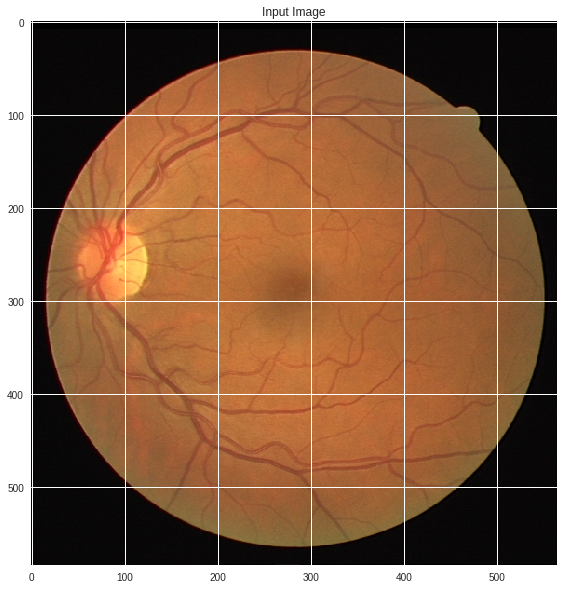

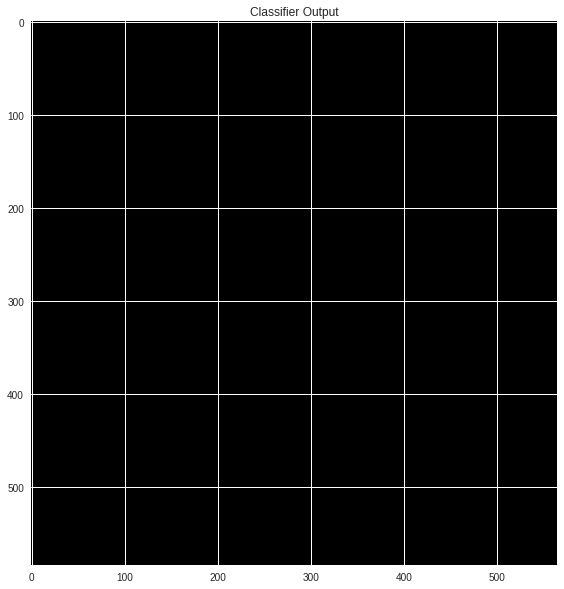

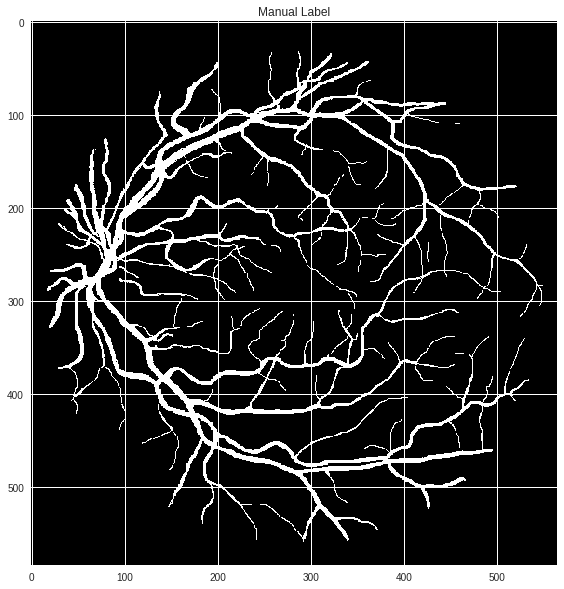

In [30]:
# Display results

plt.figure()
plt.title('Input Image')
plt.imshow(imD)

plt.figure()
plt.title('Classifier Output')
plt.imshow(imout, 'gray')

plt.figure()
plt.title('Manual Label')
plt.imshow(imL, 'gray')